# Step 1:
## Import the Modules

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('monthly-milk-production.csv',index_col='Month')
df.index = pd.to_datetime(df.index)
df.head(2)

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0


# Step 2:
### information about Dataset

In [3]:
df.isnull().sum()

Milk Production    0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


# Step 3:
### create a Min Max Scalar

In [5]:
scalar = MinMaxScaler()
Train = df.head(156)
Test = df.tail(12)
Train_Scalar = scalar.fit_transform(Train)
Test_Scalar = scalar.fit_transform(Test)

# # Step 4: Create a Batch Function:

In [6]:
def next_batch(training_data, batch_size, steps):
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)
    
    x_batch = y_batch[:, :-1].reshape(-1, steps, 1)    # Date  Shape Batch Timestep inputdim
    y_batch = y_batch[:, 1:].reshape(-1, steps, 1)     # Price STock
    return x_batch , y_batch 

# # Create RNN Model

In [7]:
num_inputs = 1
num_time_steps = 12
num_neurons = 100
num_outputs = 1
learning_rate = 0.01 
num_train_iterations = 4000
batch_size = 1

X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])


# Also play around with GRUCell
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)

output, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

loss = tf.reduce_mean(tf.square(output - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()

saver = tf.train.Saver()


with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(Train_Scalar, batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
        saver.save(sess, "./ex_time_series_soumil")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
0 	MSE: 0.30166408
100 	MSE: 0.009319085
200 	MSE: 0.008833018
300 	MSE: 0.011618547
400 	MSE: 0.009313147
500 	MSE: 0.00605657
600 	MSE: 0.0054406323
700 	MSE: 0.0037706506
800 	MSE: 0.0049413047
900 	MSE: 0.008076965
1000 	MSE: 0.0019254483
1100 	MSE: 0.0037112003
1200 	MSE: 0.010659821
1300 	MSE: 0.008058485
1400 	MSE: 0.009220048
1500 	MSE: 0.001777578
1600 	MSE: 0.0057718153
1700 	MSE: 0.0071229823
1800 	MSE: 0.0024493423
1900 	MSE: 0.0024773136
2000 	MSE: 0.

# Predict

In [8]:
Test

,Milk Production
Month,
1975-01-01 01:00:00,834.0
1975-02-01 01:00:00,782.0
1975-03-01 01:00:00,892.0
1975-04-01 01:00:00,903.0
1975-05-01 01:00:00,966.0
1975-06-01 01:00:00,937.0
1975-07-01 01:00:00,896.0
1975-08-01 01:00:00,858.0
1975-09-01 01:00:00,817.0


In [9]:
with tf.Session() as sess:
    saver.restore(sess, "./ex_time_series_soumil")
    train_seed = list(Train_Scalar[-12:])

    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(output, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./ex_time_series_soumil


In [10]:
results = scalar.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

In [11]:
len(results)

12

In [12]:
results

array([[909.3902 ],
       [895.35046],
       [939.4466 ],
       [950.2111 ],
       [985.0142 ],
       [975.57495],
       [955.30255],
       [933.80365],
       [908.66943],
       [905.27747],
       [890.92316],
       [900.888  ]], dtype=float32)

In [13]:
Test["Predicted"]  = results

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
Test

,Milk Production,Predicted
Month,,
1975-01-01 01:00:00,834.0,909.390198
1975-02-01 01:00:00,782.0,895.350464
1975-03-01 01:00:00,892.0,939.446594
1975-04-01 01:00:00,903.0,950.211121
1975-05-01 01:00:00,966.0,985.014221
1975-06-01 01:00:00,937.0,975.574951
1975-07-01 01:00:00,896.0,955.302551
1975-08-01 01:00:00,858.0,933.803650
1975-09-01 01:00:00,817.0,908.669434


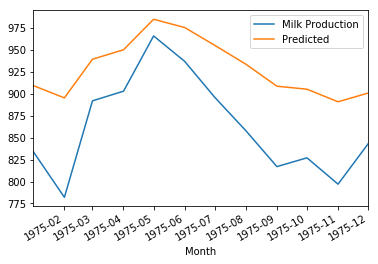

In [15]:
Test.plot()